In [80]:
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr as expr
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [81]:
rho = expr("sqrt(r**2 + a**2*cos(theta)**2)")
Delta = expr("r**2 -2*r+a**2")
Sigma = expr("sqrt((r**2+a**2)**2 -a**2*Delta*sin(theta)**2)")
alpha = expr("rho*sqrt(Delta)/Sigma")
omega = expr("2* a*r/Sigma**2")
omega_bar = expr("Sigma*sin(theta)/rho")

P = expr("r**2 + a**2 - a*b")
R = expr("P**2 - Delta*((b-a)**2+q)")
Theta = expr("q-cos(theta)**2* (b**2/sin(theta)**2-a**2)")

d_r = expr("Delta/rho**2*p_r")
d_theta = expr("1/rho**2*p_theta")

d_phi = -expr("(R(b)+Delta*Theta(b))/(2*Delta*rho**2)").diff("b")
d_p_r     = sp.diff(expr("-Delta(r)/(2*rho(r)**2)*p_r**2-1/(2*rho(r)**2)*p_theta**2+((R+Delta(r)*Theta)/(2*Delta(r)*rho(r)**2))"),"r")
d_p_theta = sp.diff(expr("-Delta/(2*rho(theta)**2)*p_r**2-1/(2*rho(theta)**2)*p_theta**2+((R(theta)+Delta(theta)*Theta(theta))/(2*Delta*rho(theta)**2))"),"theta")

In [82]:
display(rho, Delta, Sigma, alpha, omega, omega_bar)

sqrt(a**2*cos(theta)**2 + r**2)

a**2 + r**2 - 2*r

sqrt(-Delta*a**2*sin(theta)**2 + (a**2 + r**2)**2)

sqrt(Delta)*rho/Sigma

2*a*r/Sigma**2

Sigma*sin(theta)/rho

In [83]:
display(P, R, Theta)

a**2 - a*b + r**2

-Delta*(q + (-a + b)**2) + P**2

q - (-a**2 + b**2/sin(theta)**2)*cos(theta)**2

In [84]:
def metric_values(r, theta, phi, a):
    rho_v = rho.subs({"r": r, "a": a, "theta": theta}).evalf()
    Delta_v = Delta.subs({"r": r, "a": a}).evalf()
    Sigma_v = Sigma.subs({"r": r, "a": a, "theta": theta, "Delta": Delta_v}).evalf()
    alpha_v = alpha.subs({"rho": rho_v, "Delta": Delta_v, "Sigma": Sigma_v}).evalf()
    omega_v = omega.subs({"a": a, "r": r, "Sigma": Sigma_v}).evalf()
    omega_bar_v = omega_bar.subs({"a": a, "r": r, "Sigma": Sigma_v, "theta": theta, "rho": rho_v}).evalf()

    return {
        "r": r,
        "theta": theta,
        "phi": phi,
        "a": a,
        "rho": rho_v,
        "Delta": Delta_v,
        "Sigma": Sigma_v,
        "alpha": alpha_v,
        "omega": omega_v,
        "omega_bar": omega_bar_v,
    }

def sub_metric_values(expr, values):
    return expr.subs(values).evalf()

In [96]:
class Observer:
    def __init__(self, r, theta, phi, a, B_r, B_theta, B_phi):
        self.r = r
        self.theta = theta
        self.phi = phi
        self.a = a
        self.metric_values = metric_values(r, theta, phi, a)

        self.B_r = B_r 
        self.B_theta = B_theta
        self.B_phi = B_phi

        Omega = expr("1/(a+r**1.5)")
        beta = omega_bar/alpha*(Omega-omega)
        self.beta = self.sub_values(beta)

    def sub_values(self, expr):
        return sub_metric_values(expr, self.metric_values)

    def fido_ray(self, x, y, z):
        # Normalize
        L= sp.sqrt(x*x+y*y+z*z)
        N_x = (x/L).evalf()
        N_y = (y/L).evalf()
        N_z = (z/L).evalf()

        # Cartesian FIDO ray
        _ = self.sub_values(1-self.beta*N_y)
        n_Fy =  self.sub_values( (self.beta-N_y)/_ )
        n_Fx =  self.sub_values( -N_x*sp.sqrt(1-self.beta**2)/_)
        n_Fz =  self.sub_values( -N_z*sp.sqrt(1-self.beta**2)/_)

        # Spherical FIDO ray 
        kappa = sp.sqrt(1-self.B_theta**2)
        n_Fr    = self.B_phi/kappa*n_Fx + self.B_r*n_Fy+self.B_r*self.B_theta/kappa * n_Fz
        n_Ftheta= self.B_theta*n_Fy - kappa*n_Fz
        n_Fphi  = -self.B_r/kappa * n_Fx + self.B_phi*n_Fy + self.B_theta*self.B_phi/kappa*n_Fz

        # Determine conjugate momentum 
        E_f = self.sub_values(1/(expr("alpha")+expr("omega*omega_bar")*n_Fphi))
        p_t = -1 
        p_r = self.sub_values(E_f*rho/sp.sqrt(Delta)*n_Fr)
        p_theta = self.sub_values(E_f*rho*n_Ftheta)
        p_phi = self.sub_values(E_f*omega_bar*n_Fphi)

        # Constants of motion for photon
        b = p_phi 
        q = self.sub_values(p_theta**2 +sp.cos(self.theta)**2*(b**2/sp.sin(self.theta)**2-self.a**2))

        return Ray(self.r, self.theta, self.phi, p_r, p_theta, b, q, self.a)

# Get the partial derivatives with respect to b, r, theta
def partials(sym_b, sym_r=None, sym_theta=None):
    if sym_r is None and sym_theta is None: 
        sym_r = sym_b 
        sym_theta = sym_b

    return (
        sym_b.diff("b"),
        sym_r.diff("r"),
        sym_theta.diff("theta")
    )



# Expressions for partial derivatives
partials_rho = partials(rho)
partials_Delta = partials(Delta)
partials_Sigma = partials(
    Sigma,
    Sigma.subs("Delta", "Delta(r)"),
    Sigma,
)

partials_alpha = partials(
    alpha,
    alpha.subs({"rho": "rho(r)","Delta": "Delta(r)", "Sigma": "Sigma(r)"}),
    alpha.subs({"rho": "rho(theta)", "Sigma": "Sigma(theta)"}),
)

partials_P = partials(P)
partials_R = partials(
    R.subs({"P": "P(b)"}),
    R.subs({"Delta": "Delta(r)"}),
    R,
)
partials_Theta = partials(
    Theta
)

print([
        partials_rho,
    partials_Delta,
    partials_Sigma,
    partials_alpha,
    partials_P,
    partials_R,
    partials_Theta,
])

class Ray:
    def __init__(self, r, theta, phi, p_r, p_theta, b, q, a):
        self.values  = metric_values(r, theta, phi, a)

        self.values['p_r'] = p_r
        self.values['p_theta'] = p_theta
        self.values['b'] = b 
        self.values['q'] = q 

        self._calculate_values()

    def _calculate_values(self):
        self.values['P'] = self.eval(P)
        self.values['R'] = self.eval(R)
        self.values['Theta'] = self.eval(Theta)

    def eval(self, expression):
        return expression.subs(self.values).evalf()


    # Restore functional form of the expressions produced by partial derivatives to their original form
    def _replace_fns(self, expression):
        for letter in [
        'rho',
        'Delta',
        'Sigma',
        'alpha',
        'P',
        'R',
        'Theta',
        ]:
            x = sp.symbols("x")
            fn = sp.Function(letter)
            expression=expression.replace(fn, sp.Lambda((x), letter))
        return expression
    
    # Replace partial derivatives with their values
    def _replace_partials(self, expression):
        for (old, new) in self.partial_values.items(): 
            expression = expression.replace(old, new)
        return expression

    # Get the partial derivatives with respect to b, r, theta
    def _partials(self, sym_b, sym_r=None, sym_theta=None):
        if sym_r is None and sym_theta is None: 
            sym_r = sym_b 
            sym_theta = sym_b

        return (
            sym_b.diff("b"),
            sym_r.diff("r"),
            sym_theta.diff("theta")
        )

    def _calculate_partials(self):
        self.partial_values = {}

        # Evaluate partial derivatives
        for (letter, exprs) in [
            ('rho', partials_rho),
            ('Delta', partials_Delta),
            ('Sigma', partials_Sigma),
            ('alpha', partials_alpha),
            ('P', partials_P),
            ('R', partials_R),
            ('Theta', partials_Theta)
        ]:
            for (x, expression) in zip(['b', 'r', 'theta'], exprs):
                fn = sp.Function(letter)(x)
                dfn = fn.diff(x)

                expression= self._replace_partials(expression)
                expression = self._replace_fns(expression)

                self.partial_values[dfn] = self.eval(expression)
    
    def _eval_partial(self, expression):
        expression = self._replace_partials(expression)
        expression = self._replace_fns(expression)
        expression = self.eval(expression)
        return expression

    def euler_step(self, h):
        self._calculate_partials()
        
        deltas = ( 
            self.eval(d_r),
            self.eval(d_theta),
            self._eval_partial(d_phi),
            self._eval_partial(d_p_r),
            self._eval_partial(d_p_theta),
        )   

        ex =     expr("((p_r**2*(-a**2 - r**2 + 2*r) - p_theta**2)*(a**2 + r**2 - 2*r)*sin(theta)**2 + (q*sin(theta)**2 + (a**2*sin(theta)**2 - b**2)*cos(theta)**2)*(a**2 + r**2 - 2*r) + (-(q + (a - b)**2)*(a**2 + r**2 - 2*r) + (a**2 - a*b + r**2)**2)*sin(theta)**2)/(2*(a**2*cos(theta)**2 + r**2)*(a**2 + r**2 - 2*r)*sin(theta)**2)")
        
    
        print(deltas, self.eval(ex)        )


        self.r = (self.r + deltas[0]).evalf()
        self.theta = (self.theta + deltas[1]).evalf()
        self.phi = (self.phi + deltas[2]).evalf()
        self.p_r = (self.p_r + deltas[3]).evalf()
        self.p_theta = (self.p_theta + deltas[4]).evalf()
        self._update_values()

    def __str__(self):
        string = f"=== RAY {id(self)} ===\n"
        for (key, val) in self.values.items():
            string += f"\t{key}: {val}\n"
        return string

    def _update_values(self):
        self.values.update(metric_values(self.r, self.theta, self.phi, self.a))
        self._calculate_values()


    @property
    def r(self):
        return self.values['r']

    @r.setter
    def r(self, value):
        self.values['r'] = value

    @property
    def theta(self):
        return self.values['theta']

    @theta.setter
    def theta(self, value):
        self.values['theta'] = value

    @property
    def phi(self):
        return self.values['phi']

    @phi.setter
    def phi(self, value):
        self.values['phi'] = value

    @property
    def p_r(self):
        return self.values['p_r']

    @p_r.setter
    def p_r(self, value):
        self.values['p_r'] = value

    @property
    def p_theta(self):
        return self.values['p_theta']

    @p_theta.setter
    def p_theta(self, value):
        self.values['p_theta'] = value

    @property 
    def a(self):
        return self.values['a']

[(0, r/sqrt(a**2*cos(theta)**2 + r**2), -a**2*sin(theta)*cos(theta)/sqrt(a**2*cos(theta)**2 + r**2)), (0, 2*r - 2, 0), (0, (-a**2*sin(theta)**2*Derivative(Delta(r), r)/2 + 2*r*(a**2 + r**2))/sqrt(-a**2*Delta(r)*sin(theta)**2 + (a**2 + r**2)**2), -Delta*a**2*sin(theta)*cos(theta)/sqrt(-Delta*a**2*sin(theta)**2 + (a**2 + r**2)**2)), (0, sqrt(Delta(r))*Derivative(rho(r), r)/Sigma(r) - sqrt(Delta(r))*rho(r)*Derivative(Sigma(r), r)/Sigma(r)**2 + rho(r)*Derivative(Delta(r), r)/(2*sqrt(Delta(r))*Sigma(r)), sqrt(Delta)*Derivative(rho(theta), theta)/Sigma(theta) - sqrt(Delta)*rho(theta)*Derivative(Sigma(theta), theta)/Sigma(theta)**2), (-a, 2*r, 0), (-Delta*(-2*a + 2*b) + 2*P(b)*Derivative(P(b), b), -(q + (-a + b)**2)*Derivative(Delta(r), r), 0), (-2*b*cos(theta)**2/sin(theta)**2, 0, 2*b**2*cos(theta)**3/sin(theta)**3 + 2*(-a**2 + b**2/sin(theta)**2)*sin(theta)*cos(theta))]


In [97]:
# observer = Observer(4, sp.pi/2, 0, 0.999, 0.0, 0.0, 1.0)

observer = Observer(100.0, sp.pi / 2, 0, 0.0, 0.0, 0.0, 1.0)


# for theta in np.linspace(-pi / 2, pi / 2, 3, endpoint=False):
#     for phi in np.linspace(0, 2 * pi, 6, endpoint=False):
# x, y, z = 1.0, 0.0, 0.0

ray = observer.fido_ray(-1, 0, 0)
ray.euler_step(1)

-0.0204060383003680 3.04105330486687e-16


In [98]:
data = (
    [],[],[]
)

for i in range(10):
    print(i)
    ray.euler_step(-0.5)
    _r=ray.r
    _theta=ray.theta
    _phi=ray.phi
    data[0].append(0.01*(sp.sqrt(_r**2+ray.a**2)*sp.sin(_theta)*sp.cos(_phi)).evalf())
    data[1].append(0.01*(sp.sqrt(_r**2+ray.a**2)*sp.sin(_theta)*sp.sin(_phi)).evalf())
    data[2].append(0.01*(_r*sp.cos(_theta)).evalf())


0
-0.0201989503824878 0.0199996519724354
1
-0.0200000240402281 0.0394040350945040
2
-0.0198088652630450 0.0582322245328884
3
-0.0196251069518490 0.0765022442645578
4
-0.0194484066986254 0.0942311382880650
5
-0.0192784447844777 0.111435035814580
6
-0.0191149223714703 0.128129211033361
7
-0.0189575598667712 0.144328137978939
8
-0.0188060954402857 0.160045540968435
9
-0.0186602836792829 0.175294441025944


In [ ]:
print(data)

([1.01969759619059, 1.02924972539307, 1.03860654400872, 1.04776981645858, 1.05674124124893, 1.06552245386469, 1.07411502947963, 1.08252048549728, 1.09074028393510, 1.09877583366350], [0.00206061951785578, 0.00308999590336989, 0.00411851250646007, 0.00514599890578314, 0.00617229039295985, 0.00719722761328407, 0.00822065623144841, 0.00924242662013355, 0.0102623935695193, 0.0112804160159627], [6.24385973532182e-17, 6.30236531036841e-17, 6.35968089949036e-17, 6.41581713860095e-17, 6.47078426823550e-17, 6.52459215070804e-17, 6.57725028619380e-17, 6.62876782781782e-17, 6.67915359582262e-17, 6.72841609088183e-17])


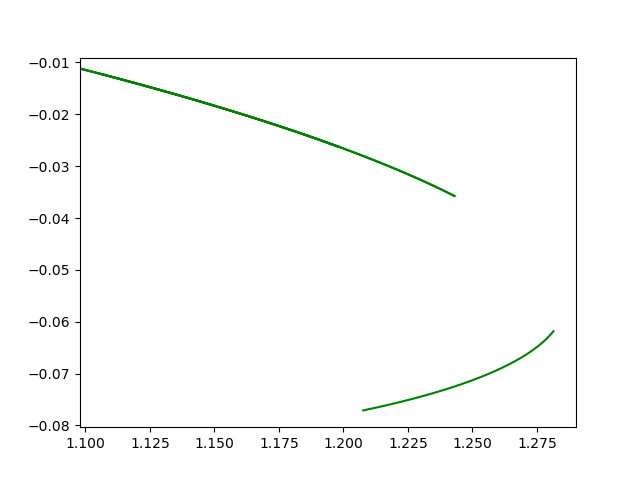

In [ ]:
%matplotlib widget
 # importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x = data[0]
y = data[1]
z = data[2]

 
# creating the plot
plt.plot(x, y, color='green')
plt.show()
 